In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from os import listdir
from os.path import isfile, join

In [10]:
file_name = './chunks/chunks.csv'
df = pd.read_csv(file_name)

dict = {0: 'bad', 1: 'neutral', 2: 'good'}
df = df.replace({'label': dict})

a = df['label'].value_counts()
list(a.index)

['neutral', 'good', 'bad']

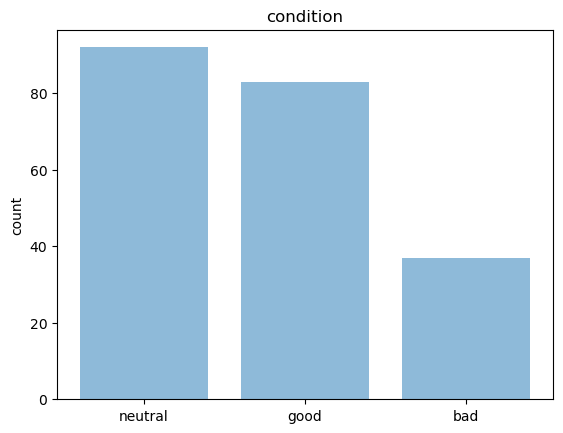

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = list(a.index)
y_pos = np.arange(len(objects))
performance = list(a)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('count')
plt.title('condition')

plt.show()

In [320]:
from torch.utils.data import Dataset

class transcription_dataset(Dataset):
 
  def __init__(self,file_name):
    file_name = './chunks/chunks.csv'
    df = pd.read_csv(file_name)
    df = df.drop('file_name', axis=1)
    df = df.drop('drop_id', axis=1)
    df['chunks'].replace('[]', np.nan, inplace=True)
    df.dropna(subset=['chunks'], inplace=True)
    df.chunks = df.chunks.apply(literal_eval)
    df.reset_index(drop=True, inplace=True)

    audio_max_length = 15000
    x = df.label.values
    y = df.iloc[:,1].values
    
    self.x_train = x
    self.y_train = y
    self.max_len = len(max(y, key=len))
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx], self.y_train[idx]

In [321]:
db = transcription_dataset('./chunks/chunks.csv')

In [322]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3])

In [323]:
train_dataset, test_dataset  = train_set, test_set
target_classes = ["bad", "neutral", "good"]

In [324]:
train_dataset[3]

(1, [1644, 3258, 5702, 10094, 10561, 11343, 14493, 15000])

In [325]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn_padd(batch):
    Y, X = list(zip(*batch))
    X = list(X)
    padded = torch.tensor([row + [0] * (db.max_len - len(row)) for row in X])
    
    return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_padd, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=collate_fn_padd)

## Model

In [326]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(db.max_len, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, len(target_classes)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and Testing

In [327]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target, *_) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = F.cross_entropy(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch}\t[{(batch_idx * len(data)):5.0f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):3.0f}%)]\tLoss: {loss.item():.4f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [328]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f" Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")
    return accuracy

In [344]:
log_interval = 20
n_epoch = 40

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
accuracies = []

model = NeuralNetwork()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)  # reduce the learning after 4 epochs by a factor of 10

with tqdm(total=n_epoch, 
          bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
          colour = 'GREEN',
          ) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        accuracy_step = test(model, epoch)
        accuracies.append(accuracy_step)
        scheduler.step()


0.00%|          | 0.00/40 [00:00<?]

C:\Users\ioci\AppData\Local\Temp\ipykernel_6364\465534958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)


Train Epoch: 1	[    0/101 (  0%)]	Loss: 714.6589
 Test Epoch: 1	Accuracy: 9/43 (21%)

Train Epoch: 2	[    0/101 (  0%)]	Loss: 167.6570
 Test Epoch: 2	Accuracy: 18/43 (42%)

Train Epoch: 3	[    0/101 (  0%)]	Loss: 54.9248
 Test Epoch: 3	Accuracy: 24/43 (56%)

Train Epoch: 4	[    0/101 (  0%)]	Loss: 18.0340
 Test Epoch: 4	Accuracy: 23/43 (53%)

Train Epoch: 5	[    0/101 (  0%)]	Loss: 4.0832
 Test Epoch: 5	Accuracy: 19/43 (44%)

Train Epoch: 6	[    0/101 (  0%)]	Loss: 12.1364
 Test Epoch: 6	Accuracy: 20/43 (47%)

Train Epoch: 7	[    0/101 (  0%)]	Loss: 11.6610
 Test Epoch: 7	Accuracy: 22/43 (51%)

Train Epoch: 8	[    0/101 (  0%)]	Loss: 10.0755
 Test Epoch: 8	Accuracy: 18/43 (42%)

Train Epoch: 9	[    0/101 (  0%)]	Loss: 5.1481
 Test Epoch: 9	Accuracy: 20/43 (47%)

Train Epoch: 10	[    0/101 (  0%)]	Loss: 4.2139
 Test Epoch: 10	Accuracy: 22/43 (51%)

Train Epoch: 11	[    0/101 (  0%)]	Loss: 11.5833
 Test Epoch: 11	Accuracy: 18/43 (42%)

Train Epoch: 12	[    0/101 (  0%)]	Loss: 3.9572
 Tes

Text(0.5, 1.0, 'training loss')

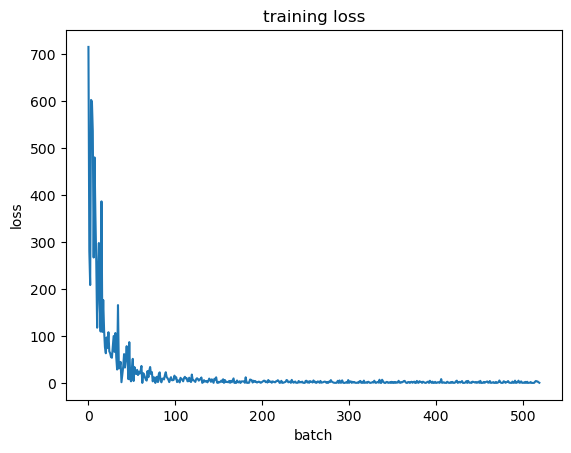

In [345]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title("training loss")

Text(0.5, 1.0, 'training accuracy')

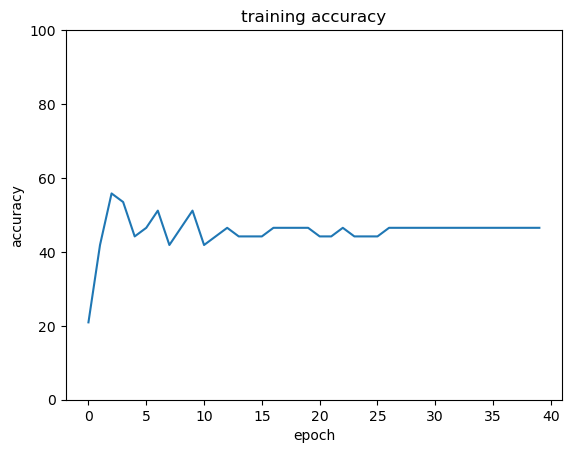

In [346]:
ax = plt.plot(accuracies)

plt.ylim(0, 100)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(0, len(accuracies)+1, 5))
plt.title("training accuracy")

In [347]:
print(count_parameters(model))

682499


C:\Users\ioci\AppData\Local\Temp\ipykernel_6364\465534958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)


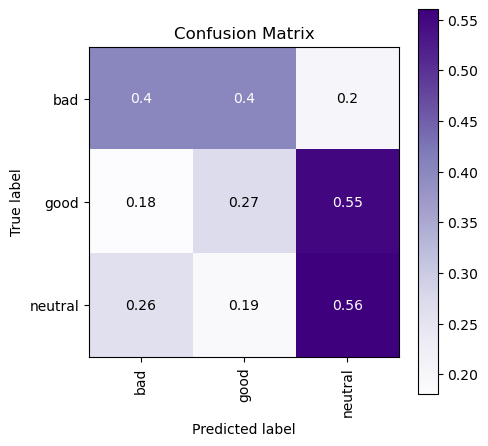

In [348]:
target_classes = {0:"bad", 1:"neutral", 2:"good"}

def print_results(Y_actual, Y_preds, target_names):
    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    import numpy as np

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def make_predictions(model):
    Y_shuffled, Y_preds = [], []

    model.eval()
    correct = 0

    with torch.no_grad():
       for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        predicted_label = model(data)

        Y_preds.append(predicted_label)
        Y_shuffled.append(target)
            
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()


Y_actual, Y_preds = make_predictions(model)
print_results(Y_actual, Y_preds, target_classes)